In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from scipy.stats import norm
from scipy import stats

from sklearn import ensemble
from matplotlib import style
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
%matplotlib inline

# Загрузка данных

In [154]:
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')

# Просмотр зависимостей

In [155]:
feature_names = train.columns.to_list()
df_feautre_names = train.select_dtypes(include=['float64', 'int64'])
num_features = pd.DataFrame(df_feautre_names)

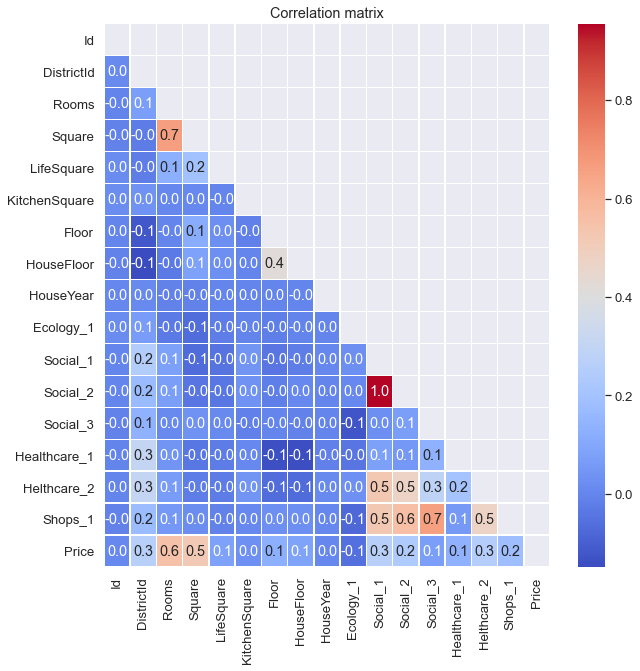

In [156]:
# строим матрицу корреляций
corr = df_feautre_names.corr()
plt.figure(figsize=(10, 10))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.2)
sns.heatmap(df_feautre_names.corr(), mask=mask, annot=True, fmt='.1f', linewidths=0.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

# Исследование на выбросы

SwarmPlot. Price depending by Rooms

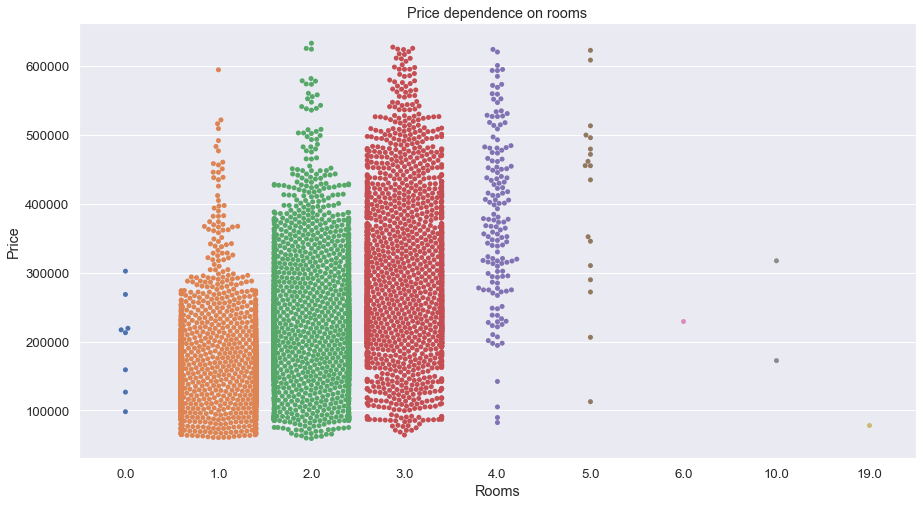

In [157]:
plt.figure(figsize=(15, 8))
sns.swarmplot(train['Rooms'], train['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('Price dependence on rooms')
plt.show()

Scatter. Price depending by Square

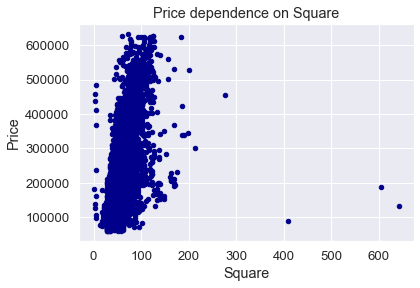

In [158]:
scatter_square = pd.concat([train['Price'], train['Square']], axis=1)
scatter_square.plot.scatter(x='Square', y='Price', c='DarkBlue')
plt.title('Price dependence on Square')
plt.show()

Scatter. Price depending on LifeSquare

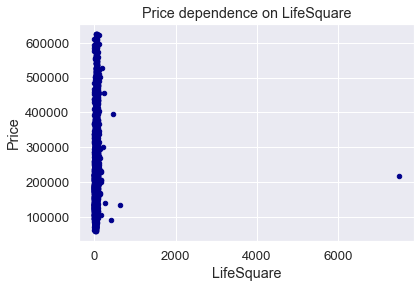

In [159]:
scatter_lifesquare = pd.concat([train['Price'], train['LifeSquare']], axis=1)
scatter_lifesquare.plot.scatter(x='LifeSquare', y='Price', c='DarkBlue')
plt.title('Price dependence on LifeSquare')
plt.show()

Признаки

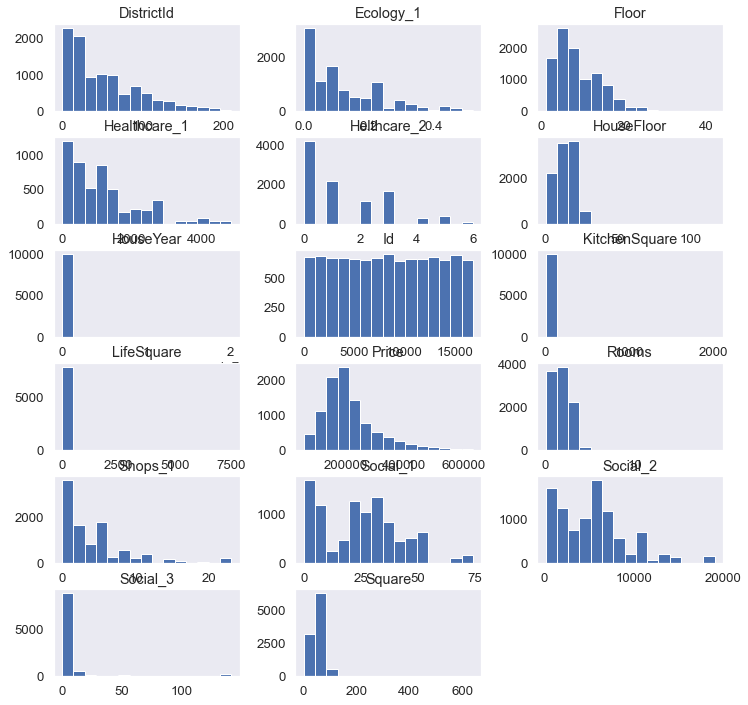

In [160]:
train_features = train.select_dtypes(include=['float64', 'int64'])
df_train_features = pd.DataFrame(train_features)
df_train_features.hist(figsize=(12, 12), bins=15, grid=False, layout=(6, 3))
plt.show()

Очистка данных

In [161]:
train = train.sort_values('Price')

In [162]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')

In [163]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [164]:
# очистка выбросов Square
sort_by_square = train.sort_values(by='Square', ascending=False)
wasted_square = sort_by_square.loc[:, 'Square'][:3].index.to_list()
train = train.drop(wasted_square)
#train.sort_values(by='Square', ascending=False)

In [165]:
# Очистка выбросов HouseYear
sort_by_houseyear = train.sort_values(by='HouseYear', ascending=False)
wasted_houseyear = sort_by_houseyear.loc[:, 'HouseYear'][:2].index.to_list()
train = train.drop(wasted_houseyear)
#train.sort_values(by='HouseYear', ascending=False)

In [166]:
# Очистка выбросов Rooms
sort_by_rooms = train.sort_values(by='Rooms', ascending=False)
wasted_rooms = sort_by_rooms.loc[:, 'Rooms'][:3].index.to_list()
train = train.drop(wasted_rooms)
#train.sort_values(by='Rooms', ascending=False)

In [167]:
# Очистка выбросов LifeSquare
sort_by_lifesquare = train.sort_values(by='LifeSquare', ascending=False)
wasted_lifesquare = sort_by_lifesquare.loc[:, 'LifeSquare'][:6].index.to_list()
train = train.drop(wasted_lifesquare)
#train.sort_values(by='LifeSquare', ascending=False)

Заполненение пропусков и выбросов

In [168]:
class FeatureCorrector:
    # класс для корректировки фичей
    
    def __init__(self):
        
        self.medians = None
        
    def fit(self, df):
        
        self.medians = df.median()
    
    def transform(self, df):
        
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] 
        df.loc[(df['Rooms'] > 5) & (df['Square'] < 50),'Rooms'] = 2
        
        df.loc[df['Square'] < 10,'Square']= df.loc[df['Square'] < 10,'Square'] * 10
        df.loc[df['Square'] < 1,'Square'] = df.loc[df['Square']< 1,'Square'] * 100 
        df.loc[df['Square'] > 250, 'Square'] = self.medians['Square']
        
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        
        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        df.loc[df['KitchenSquare'] > 1000, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']
        
        current_year = now = datetime.datetime.now().year
        
        df['HouseYear_outlier'] = 0
        df.loc[df['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        df.loc[df['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        if 'Healthcare_1' in df.columns:
            df.drop('Healthcare_1', axis=1, inplace=True)
        
        df.loc[(df['LifeSquare'] > 200) &\
               (df['Square'] < 100),'LifeSquare'] = df.loc[(df['LifeSquare'] > 200) & (df['Square'] < 100),'LifeSquare'] / 10
        
        df['LifeSquare_nan'] = df['LifeSquare'].isna() * 1
        
        clause = (df['LifeSquare'].isna()) &\
                      (~df['Square'].isna()) &\
                      (~df['KitchenSquare'].isna())
        
        df.loc[clause, 'LifeSquare'] = df.loc[clause, 'Square'] * 0.65
        
        
        return df

In [169]:
class FeatureGenerator():
    # генерация фичей(точнее замена A и B в фиче на бинарный тип 0 и 1)
    
    def __init__(self):
        
        self.bin_as_num = None
    
    def fit(self, df):
        
        self.bin_as_num = {'A': 0, 'B': 1}
    
    def transform(self, df):
        
        df['Ecology_2'] = df['Ecology_2'].map(self.bin_as_num)
        df['Ecology_3'] = df['Ecology_3'].map(self.bin_as_num)
        df['Shops_2'] = df['Shops_2'].map(self.bin_as_num)
    
        return df

In [170]:
corrector = FeatureCorrector()

corrector.fit(train)

train = corrector.transform(train)
test = corrector.transform(test)

In [171]:
feature_gen = FeatureGenerator()

feature_gen.fit(train)

train = feature_gen.transform(train)
test = feature_gen.transform(test)

In [172]:
# заполнение полей NaN
train = train.fillna(method='pad')
test = test.fillna(method='pad')

Проверка

In [173]:
y = train.Price
train.drop("Price", axis=1, inplace=True)
train.drop("Id", axis=1, inplace=True)
y

9732     59174.778028
3605     59877.592523
7850     60502.583500
9961     60825.032060
6856     60828.260686
            ...      
3228    624680.099059
4764    625678.644994
1537    625820.041178
8143    627525.072788
6794    633233.466570
Name: Price, Length: 9986, dtype: float64

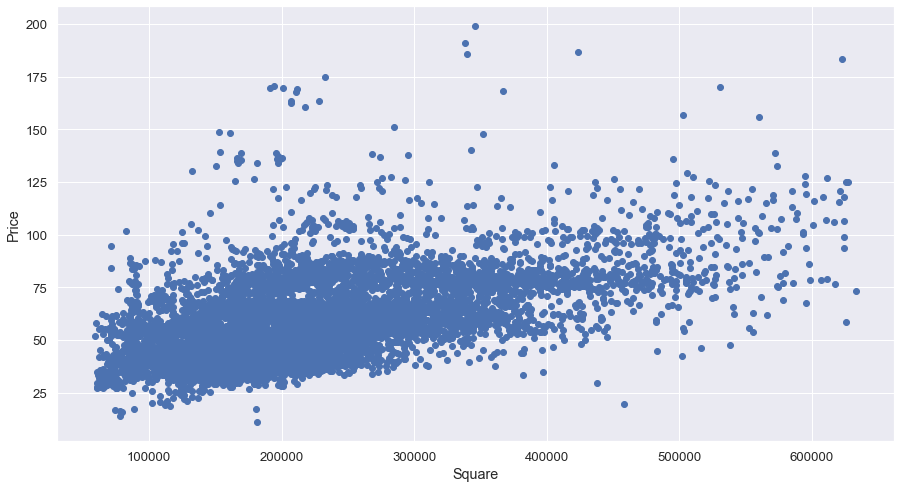

In [174]:
plt.figure(figsize=(15, 8))
plt.scatter(y, train.Square)
plt.ylabel('Price')
plt.xlabel('Square')
plt.show()

Модель

In [175]:
train = pd.get_dummies(train)

In [176]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9986 entries, 9732 to 6794
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DistrictId          9986 non-null   int64  
 1   Rooms               9986 non-null   float64
 2   Square              9986 non-null   float64
 3   LifeSquare          9986 non-null   float64
 4   KitchenSquare       9986 non-null   float64
 5   Floor               9986 non-null   float64
 6   HouseFloor          9986 non-null   float64
 7   HouseYear           9986 non-null   float64
 8   Ecology_1           9986 non-null   float64
 9   Ecology_2           9986 non-null   int64  
 10  Ecology_3           9986 non-null   int64  
 11  Social_1            9986 non-null   int64  
 12  Social_2            9986 non-null   int64  
 13  Social_3            9986 non-null   int64  
 14  Helthcare_2         9986 non-null   int64  
 15  Shops_1             9986 non-null   int64  
 16  Sho

In [178]:
rfr = RandomForestRegressor(n_estimators=300, max_depth=18, random_state=42, max_features=7)

cros_val = cross_val_score(rfr, train, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# среднее и ошибка
mean = cros_val.mean()
std = cros_val.std()

print(f'R2: {round(mean, 5)} +- {round(std, 5)}')

R2: 0.7395 +- 0.01627


In [179]:
lgbmr = LGBMRegressor(max_depth=6,
                             num_leaves=12,
                             n_estimators=300,
                             random_state=42)

cros_val = cross_val_score(lgbmr, train, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# среднее и ошибка
mean = cros_val.mean()
std = cros_val.std()

print(f'R2: {round(mean, 5)} +- {round(std, 5)}')

R2: 0.74763 +- 0.02327


In [177]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=300, max_depth=6, min_samples_split=2,
                                           learning_rate=0.1, loss='ls', random_state=42)
cros_val = cross_val_score(gbr, train, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# среднее и ошибка
mean = cros_val.mean()
std = cros_val.std()

print(f'R2: {round(mean, 5)} +- {round(std, 5)}')

R2: 0.73987 +- 0.02036


In [180]:
model = VotingRegressor([('gbr', gbr), ('rfr', rfr), ('lgbmr', lgbmr)])

In [181]:
cros_val = cross_val_score(model, train, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# среднее и ошибка
mean = cros_val.mean()
std = cros_val.std()

print(f'R2: {round(mean, 5)} +- {round(std, 5)}')

R2: 0.75456 +- 0.01871


In [182]:
model.fit(train, y)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(max_depth=6,
                                                       n_estimators=300,
                                                       random_state=42)),
                            ('rfr',
                             RandomForestRegressor(max_depth=18, max_features=7,
                                                   n_estimators=300,
                                                   random_state=42)),
                            ('lgbmr',
                             LGBMRegressor(max_depth=6, n_estimators=300,
                                           num_leaves=12, random_state=42))])

# Применение модели и получение предсказаний

In [183]:
X_test = pd.get_dummies(test)
X_test.drop("Id", axis=1, inplace=True)



test["Price"] = model.predict(X_test)
test.loc[:, ['Id', 'Price']].to_csv('final_prediction.csv', index=False)
test.loc[:, ['Id', 'Price']].head(20)

,Id,Price
0,725,158774.183048
1,15856,222671.166907
2,5480,198532.522789
3,15664,357175.856907
4,14275,141579.407729
5,7633,211827.287591
6,13329,171445.774244
7,5502,220365.881742
8,4220,294033.157036
9,11538,192305.387563
